# Runtime Monitoring Neuron Activation Patterns (2) - German Traffic Sign Recognition Benchmark (GTSRB)

For detailed explanation, please refer to the jupyter notebook 1_MNIST_Pytorch_CNN.ipydb

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy.random
# Fix the number for repeatability (we have also stored the trained model)
numpy.random.seed(42)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Start by accessing the root folder where internally, subfolders are images with folder name being their classified result.

The dataset should be available at the following site 
http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

Here we just pick the 26K smaller training set (the online version), as the training and test set can all be directly loaded using PyTorch included functionalities. 

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

standard_transform = transforms.Compose([
        transforms.ToTensor(),
        # Change the image to PIL format, such that resize can be done
        transforms.ToPILImage(),
        transforms.Resize((32,32)),
        # Bring it back to tensor
        transforms.ToTensor()
    ])

# Here the data is not be normalized to [-1,1]

# Change the folder based on your specific needs. 
# This one is a smaller (26640 examples) data set (for online training), so the 
data = ImageFolder(root='data/GTSRB-Training_fixed/GTSRB/Training',  transform=standard_transform)


In [4]:
print(data.classes)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


- 0 	 Speed limit (20km/h)
- 1 	 Speed limit (30km/h)
- 2 	 Speed limit (50km/h)
- 3 	 Speed limit (60km/h)
- 4 	 Speed limit (70km/h)
- 5 	 Speed limit (80km/h)
- 6 	 End of speed limit (80km/h)
- 7 	 Speed limit (100km/h)
- 8 	 Speed limit (120km/h)
- 9 	 No passing
- 10 	 No passing for vechiles over 3.5 metric tons
- 11 	 Right-of-way at the next intersection
- 12 	 Priority road
- 13 	 Yield
- 14 	 Stop
- 15 	 No vechiles
- 16 	 Vechiles over 3.5 metric tons prohibited
- 17 	 No entry
- 18 	 General caution
- 19 	 Dangerous curve to the left
- 20 	 Dangerous curve to the right
- 21 Double curve
- 22 	 Bumpy road
- 23 	 Slippery road
- 24 	 Road narrows on the right
- 25 	 Road work
- 26 	 Traffic signals
- 27 	 Pedestrians
- 28 	 Children crossing
- 29 	 Bicycles crossing
- 30 	 Beware of ice/snow
- 31 	 Wild animals crossing
- 32 	 End of all speed and passing limits
- 33 	 Turn right ahead
- 34 	 Turn left ahead
- 35 	 Ahead only
- 36 	 Go straight or right
- 37 	 Go straight or left
- 38 	 Keep right
- 39 	 Keep left
- 40 	 Roundabout mandatory
- 41 	 End of no passing
- 42 	 End of no passing by vechiles over 3.5 metric tons



In [5]:
# Hyper-parameters 
num_classes = 43
learning_rate = 0.001
sizeOfNeuronsToMonitor = 84
batch_size = 64
num_epochs = 5

In [6]:
from torch.utils.data import DataLoader

loader = DataLoader(data, batch_size=batch_size, shuffle=True)

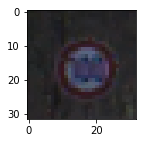

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import util

# get some random training images
dataiter = iter(loader)
images, labels = dataiter.next()

# print(images.shape)
util.displayGTSRB(images[0].numpy())


In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 40, 5)
        self.conv1_bn = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 20, 5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(20 * 5 * 5, 240)        
        self.fc2 = nn.Linear(240, sizeOfNeuronsToMonitor)
        self.fc3 = nn.Linear(sizeOfNeuronsToMonitor, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn((self.conv2(x)))))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forwardWithIntermediate(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn((self.conv2(x)))))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        intermediateValues = F.relu(self.fc2(x))
        x = self.fc3(intermediateValues)
        return x , intermediateValues


In [9]:
net = Net()

In [10]:
# .. to load pre-trained model:
net.load_state_dict(torch.load('models/3_model_GTSRB_CNN_27k_train99%.ckpt'))

In [11]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

furtherTrain = False

if furtherTrain: 

    # Train the model
    total_step = len(loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):  
            # Move tensors to the configured device
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    print('Finished Training')

For testing, we should also use the test data, where they are separated into folders based on their classes, followed by shuffling.

In [12]:
from torch.utils.data import DataLoader

testdata = ImageFolder(root='data/GTSRB_Online-Test-Images-Sorted/GTSRB/Online-Test-sort', transform=standard_transform)
testloader = DataLoader(testdata, shuffle=True)

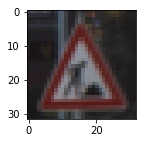

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

util.displayGTSRB(images[0].numpy())

In [14]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print(predicted)
print(labels)

tensor([ 25])
tensor([ 25])


In [15]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        label = labels[0]
        class_correct[label] += c[0].item()
        class_total[label] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network over test images: {} %\n\n'.format(100 * correct / total))

for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))
    

Accuracy of the network over test images: 96.39589466146869 %


Accuracy of     0 : 88 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 95 %
Accuracy of     5 : 92 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %
Accuracy of    10 : 98 %
Accuracy of    11 : 95 %
Accuracy of    12 : 99 %
Accuracy of    13 : 99 %
Accuracy of    14 : 96 %
Accuracy of    15 : 93 %
Accuracy of    16 : 100 %
Accuracy of    17 : 99 %
Accuracy of    18 : 97 %
Accuracy of    19 : 100 %
Accuracy of    20 : 99 %
Accuracy of    21 : 37 %
Accuracy of    22 : 98 %
Accuracy of    23 : 87 %
Accuracy of    24 : 94 %
Accuracy of    25 : 99 %
Accuracy of    26 : 91 %
Accuracy of    27 : 100 %
Accuracy of    28 : 91 %
Accuracy of    29 : 62 %
Accuracy of    30 : 92 %
Accuracy of    31 : 96 %
Accuracy of    32 : 100 %
Accuracy of    33 : 95 %
Accuracy of    34 : 100 %
Accuracy of    35 : 99 %
Accuracy of    36 : 100 %
Accur

In [16]:
with torch.no_grad():
    
    correct = 0
    total = 0
    for data in loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network over train images: {} %\n\n'.format(100 * correct / total))


    

Accuracy of the network over train images: 99.93243243243244 %




# Runtime monitoring

We consider monitoring the stop sign class, where apart from monitoring the complete neurons in fc3 (a total of 84 neurons), we take those whose impact (represented by the outgoing weight - in this case, the weight is the partial derivitative) is higher. 

In [17]:
stopSignClass = 14

weightsStopSignClass = None
neuronIndicesToBeOmitted = {}

# As a parameter to derive the number of neurons to be tracked
filteringRate = 0.45

for name, param in net.named_parameters():
    if name == "fc3.weight":
        print(name, param.data[stopSignClass])
        weightsStopSignClass = param.data[stopSignClass].numpy()
        
absWeight = np.absolute(weightsStopSignClass)
maxWeightQuantity = np.max(absWeight)

neuronIndicesToBeOmittedByStopSign = set()

for i in range(len(absWeight)):
    if(absWeight[i] <= filteringRate * maxWeightQuantity):
        neuronIndicesToBeOmittedByStopSign.add(i)

# print(neuronIndicesToBeOmittedByStopSign)

neuronIndicesToBeOmitted[stopSignClass] = neuronIndicesToBeOmittedByStopSign
print("neurons omitted for monitoring: "+str(len(neuronIndicesToBeOmitted[stopSignClass])))

fc3.weight tensor([-0.8384, -0.6619, -0.6385, -0.3713,  0.0685, -0.9585, -0.1548,
        -0.8818, -0.7139, -0.9509,  0.1551, -0.5067, -1.6361, -0.0824,
        -0.6102, -0.9059, -0.0051, -0.9088, -0.1104, -1.0027, -0.4363,
         0.0878, -0.1808, -0.6895, -0.5737,  0.1477, -0.0297, -0.4882,
        -0.0085,  0.0617, -0.0161, -0.3357, -0.0453, -0.0137,  0.0956,
        -0.8550, -0.1750, -0.5308, -0.5634, -0.1976, -1.1292, -0.1395,
        -0.9964, -0.2545, -0.7173,  0.0244, -0.9996, -0.0917,  0.0716,
        -1.2760, -0.2818, -0.3805, -0.6418, -1.0037, -1.3294, -0.0093,
         0.1419, -0.0160,  0.0150, -0.5254, -0.9061, -0.2340, -1.5008,
        -0.1813,  0.1064, -0.1602, -0.2963, -0.6089, -0.7957,  0.1285,
        -0.0941, -0.0856, -0.0253, -0.5752, -0.6543, -0.4661, -0.8133,
        -0.5880, -0.7916, -1.1879, -0.6502,  0.1297, -0.7753, -0.5738])
neurons omitted for monitoring: 62


## Part 1. Trigger neuron on-off activation pattern monitoring

Here we pretend that test set is the "real data" after deployment, so we only record neuron activation patterns inside the training set. 

Notice: The BDD can consume a lot memory (>12GB)! This is because we do not apply any variable re-ordering techniques to reduce the size. Before actual deployment for run-time monitoring, one should perform proper reordering.

Therefore, here we restrict ourselves to the classification of stop sign, so the monitor size can be smaller. 

In [18]:
from nndependability.rv import napmonitor
monitor = napmonitor.NAP_Monitor(num_classes, sizeOfNeuronsToMonitor, neuronIndicesToBeOmitted)

In [19]:
## Scan the training set and store activation pattern on BDD

stopSignClass = 14

testOnAllClasses = False

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if testOnAllClasses:
            # Add the batch of neuron activation patterns to the monitor, for Hamming distance = 0, and for all classes. 
            monitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), -1)
        else:
            monitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), stopSignClass)            

     
    print('Accuracy of the network on the all train images: {} %'.format(100 * correct / total))


Accuracy of the network on the all train images: 99.91741741741741 %


In [20]:
# We don't need to compute gradients (for memory efficiency)

def testMonitor(testOnAllClasses, loader, monitor):
    
    with torch.no_grad():
        
        total = 0
        correct = 0
        correctStopSign = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        totalStopSign = 0
        for images, labels in loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            # Additional processing for runtime monitoring
            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]):   
                # Check if the prediction says that it is a stop sign
                if testOnAllClasses or ((not testOnAllClasses) and predicted.numpy()[exampleIndex] == stopSignClass):
                    if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                        outofActivationPattern = outofActivationPattern +1
                        if res[exampleIndex] == False :
                            outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong+ 1
            
    if testOnAllClasses:
        print('Accuracy of the network on the GTSRB test images: {} %'.format(100 * correct / total))
        print('Out-of-activation pattern on the GTSRB test images: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (total - correct)))

    else: 
        print('Accuracy of the network on total GTSRB test images, for stop sign: {} %'.format(100 * class_correct[stopSignClass] / class_total[stopSignClass]))
        print('Out-of-extended activation pattern on GTSRB test images, for stop sign: {} %'.format(100 * outofActivationPattern / class_total[stopSignClass]))
        print('Out-of-extended activation pattern & misclassified / out-of-extended activation pattern (stop sign) : {} %'.format(100 * outofActivationPatternAndResultWrong / outofActivationPattern))


In [21]:
testMonitor(testOnAllClasses, testloader, monitor)

Accuracy of the network on total GTSRB test images, for stop sign: 96.66666666666667 %
Out-of-extended activation pattern on GTSRB test images, for stop sign: 32.916666666666664 %
Out-of-extended activation pattern & misclassified / out-of-extended activation pattern (stop sign) : 10.126582278481013 %


#### Produce adversarial training example using iterative FGSM and check if the activation pattern is within

In [22]:
import util 


def performAdversarialExamination(testOnAllClasses, loader, monitor):
    
    originalImages = []
    originalLabels = []
    attackedImages = []

    notInNeuronActivationPattern = 0
    totalPerturbed = 0

    # Note: Only perform analysis when the monitor takes all classes
    if testOnAllClasses:

        for images, labels in loader:
            # print(list(images.size())[0])

            for i in range(list(images.size())[0]):
                if testOnAllClasses:
                    adv_img, noise, attackSuccessful = util.iterative_FGSM_attack(images[i].unsqueeze(0), labels[i].unsqueeze(0), net)

                    if (attackSuccessful) :
                        totalPerturbed = totalPerturbed + 1

                        out, intermediateValues = net.forwardWithIntermediate(adv_img)  
                        _, predicted = torch.max(out.data, 1)
                        iv = intermediateValues.detach().numpy()
                        mat = np.zeros(intermediateValues.shape)
                        ivabs = np.greater(iv, mat)

                        for exampleIndex in range(iv.shape[0]): 
                            if not monitor.isOnOffPatternContained(ivabs[exampleIndex,:], predicted.numpy()[exampleIndex]):
                                notInNeuronActivationPattern = notInNeuronActivationPattern +1


            print('not in neuron activation pattern / all total perturbed: {} %'.format(100 * notInNeuronActivationPattern / totalPerturbed))
    else:
        # Try to perturb, hopefully perturbed to stop sign
        targetedPerturbedClass = torch.ones(1, dtype=torch.long)
        targetedPerturbedClass[0] = stopSignClass

        for images, labels in loader:
            # print(list(images.size())[0])

            for i in range(list(images.size())[0]):
                if(testOnAllClasses or ((not testOnAllClasses) and labels[i].unsqueeze(0) != stopSignClass)):
                    # From those image that are not stop sign, and perturb them.
                    adv_img, noise, attackSuccessful = util.iterative_targeted_FGSM_attack(images[i].unsqueeze(0), labels[i].unsqueeze(0), targetedPerturbedClass, net)

                    if (attackSuccessful) :
                        totalPerturbed = totalPerturbed + 1

                        if(totalPerturbed % 100 == 0):
                            print(totalPerturbed)
                            originalImages.append(images[i])
                            originalLabels.append(labels[i])
                            attackedImages.append(adv_img)

                        if(totalPerturbed > 2000):
                            # In the worst case, we only perturn 2000 images
                            break

                        # util.displayGTSRB(adv_img[0].numpy())
                        out, intermediateValues = net.forwardWithIntermediate(adv_img)  
                        _, predicted = torch.max(out.data, 1)
                        iv = intermediateValues.detach().numpy()
                        mat = np.zeros(intermediateValues.shape)
                        ivabs = np.greater(iv, mat)

                        for exampleIndex in range(iv.shape[0]):                             
                            if not monitor.isOnOffPatternContained(ivabs[exampleIndex,:], predicted.numpy()[exampleIndex]):
                                notInNeuronActivationPattern = notInNeuronActivationPattern +1




    if(totalPerturbed>0):
        print('not in neuron activation pattern / all total perturbed: {} %'.format(100 * notInNeuronActivationPattern / totalPerturbed))
        print('all total perturbed = '+str(totalPerturbed))
    else:
        print('No image can be perturbed to the desired class!')
        

In [23]:
isTestAdv = False

In [24]:
if isTestAdv:
    performAdversarialExamination(testOnAllClasses, testloader, monitor)

In [25]:
monitor.enlargeSetByOneBitFluctuation(stopSignClass)

In [26]:
testMonitor(testOnAllClasses, testloader, monitor)

Accuracy of the network on total GTSRB test images, for stop sign: 96.66666666666667 %
Out-of-extended activation pattern on GTSRB test images, for stop sign: 15.0 %
Out-of-extended activation pattern & misclassified / out-of-extended activation pattern (stop sign) : 19.444444444444443 %


In [27]:
if isTestAdv:
    performAdversarialExamination(testOnAllClasses, testloader, monitor)

In [28]:
monitor.enlargeSetByOneBitFluctuation(stopSignClass)

In [29]:
testMonitor(testOnAllClasses, testloader, monitor)

Accuracy of the network on total GTSRB test images, for stop sign: 96.66666666666667 %
Out-of-extended activation pattern on GTSRB test images, for stop sign: 7.083333333333333 %
Out-of-extended activation pattern & misclassified / out-of-extended activation pattern (stop sign) : 41.1764705882353 %


In [30]:
if isTestAdv:
    performAdversarialExamination(testOnAllClasses, testloader, monitor)

In [31]:
monitor.enlargeSetByOneBitFluctuation(stopSignClass)

In [32]:
testMonitor(testOnAllClasses, testloader, monitor)

Accuracy of the network on total GTSRB test images, for stop sign: 96.66666666666667 %
Out-of-extended activation pattern on GTSRB test images, for stop sign: 4.166666666666667 %
Out-of-extended activation pattern & misclassified / out-of-extended activation pattern (stop sign) : 50.0 %


In [33]:
if isTestAdv:
    performAdversarialExamination(testOnAllClasses, testloader, monitor)

### Pretty print some adversarial examples

tensor([ 31])
tensor([ 31])


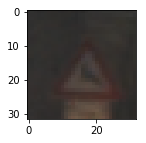

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print(predicted)
print(labels)

util.displayGTSRB(images[0].numpy())

In [35]:
import util

img = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)

adv_img, noise, attackSuccessful = util.iterative_FGSM_attack(img, label, net)

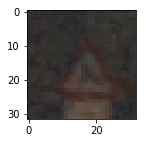

In [36]:
if attackSuccessful :
    util.displayGTSRB(adv_img[0].numpy())
else: 
    print("iterative FGSM is not effective")

If we directly print the noise, we got complaints as the value is not within [0, 1]. Therefore, we add each pixel of RGB with 0.5 to display the effect. 

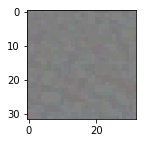

In [37]:
if attackSuccessful :
    util.displayGTSRB(noise[0].numpy()+0.5)

Let's check if the adversarial image produces any similar activation pattern.


In [38]:
out, intermediateValues = net.forwardWithIntermediate(adv_img)        
print(out.data)

tensor([[-121.6396,  -93.9314, -101.0680,  -91.9746, -102.9971,  -85.6052,
         -119.5304,  -78.7190,  -73.2300,  -79.1243,  -85.2275,  -47.8832,
          -77.4093,  -84.3630, -110.5437,  -88.9491, -103.9588,  -94.7603,
          -54.7842,  -74.1591,  -50.2831,  -76.3618,  -86.4259,  -48.7458,
          -35.3232,  -53.7251,  -64.8733,  -68.1852,  -28.1999,  -38.6478,
          -26.3842,  -80.3612,  -87.7052,  -75.2408,  -82.8970,  -89.0443,
          -88.8850, -104.3346,  -88.8350, -114.4325,  -97.4341,  -70.1792,
          -85.7480]])


In [39]:
_, predicted = torch.max(out.data, 1)
iv = intermediateValues.detach().numpy()
mat = np.zeros(intermediateValues.shape)
ivabs = np.greater(iv, mat)

# Note: Only perform analysis when the monitor takes all classes
if testOnAllClasses:
    for exampleIndex in range(iv.shape[0]):      
        if not monitor.isPatternContained(intermediateValues.detach().numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
            print("Adv example is not within activation pattern")
        else:
            print("Adv example is within activation pattern")

# Part 2 (Optional). Trigger neuron interval activation pattern monitoring

In [40]:
stopSignClass = 14

weightsStopSignClass = None
neuronIndicesToBeOmitted = {}

# As a parameter to derive the number of neurons to be tracked
filteringRate = 0.3

for name, param in net.named_parameters():
    if name == "fc3.weight":
        print(name, param.data[stopSignClass])
        weightsStopSignClass = param.data[stopSignClass].numpy()
        
absWeight = np.absolute(weightsStopSignClass)
maxWeightQuantity = np.max(absWeight)

neuronIndicesToBeOmittedByStopSign = set()

for i in range(len(absWeight)):
    if(absWeight[i] <= filteringRate * maxWeightQuantity):
        neuronIndicesToBeOmittedByStopSign.add(i)

# print(neuronIndicesToBeOmittedByStopSign)

neuronIndicesToBeOmitted[stopSignClass] = neuronIndicesToBeOmittedByStopSign
print("neurons omitted for monitoring: "+str(len(neuronIndicesToBeOmitted[stopSignClass])))

fc3.weight tensor([-0.8384, -0.6619, -0.6385, -0.3713,  0.0685, -0.9585, -0.1548,
        -0.8818, -0.7139, -0.9509,  0.1551, -0.5067, -1.6361, -0.0824,
        -0.6102, -0.9059, -0.0051, -0.9088, -0.1104, -1.0027, -0.4363,
         0.0878, -0.1808, -0.6895, -0.5737,  0.1477, -0.0297, -0.4882,
        -0.0085,  0.0617, -0.0161, -0.3357, -0.0453, -0.0137,  0.0956,
        -0.8550, -0.1750, -0.5308, -0.5634, -0.1976, -1.1292, -0.1395,
        -0.9964, -0.2545, -0.7173,  0.0244, -0.9996, -0.0917,  0.0716,
        -1.2760, -0.2818, -0.3805, -0.6418, -1.0037, -1.3294, -0.0093,
         0.1419, -0.0160,  0.0150, -0.5254, -0.9061, -0.2340, -1.5008,
        -0.1813,  0.1064, -0.1602, -0.2963, -0.6089, -0.7957,  0.1285,
        -0.0941, -0.0856, -0.0253, -0.5752, -0.6543, -0.4661, -0.8133,
        -0.5880, -0.7916, -1.1879, -0.6502,  0.1297, -0.7753, -0.5738])
neurons omitted for monitoring: 44


In [41]:
maximumValues = np.zeros([1, sizeOfNeuronsToMonitor])

# We don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    
    total = 0
    for images, labels in testloader:
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
    
    for exampleIndex in range(intermediateValues.shape[0]):   
        maximumValues = np.maximum(intermediateValues.numpy()[exampleIndex,:], maximumValues)
    
    print(maximumValues)

[[ 0.          0.          0.          0.          0.          0.
   0.          1.51043105 11.33450413 12.76471806  0.         31.3404789
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  13.8808651   0.          0.          0.          0.         22.09344864
   0.          0.83835924  0.          0.         10.54615593 14.99170303
   0.          6.42734003  0.          0.          0.          0.
   4.78947401  0.         11.05724335  6.33393431 26.40835381  0.
   0.          0.          0.          4.87903976  0.          8.22242737
   0.          0.          5.50282145  0.          0.          0.
   0.          5.50900841  3.91941404  0.          7.86844444  0.51435292
   0.          4.19713306  0.          0.          0.          0.
   0.          0.          0.          0.          0.78366673 26.7183075
  19.46404266  1.59299719  9.16172504  0.          0.          3.92436075]]


In [42]:
threshold1 = (maximumValues*1)/3
threshold2 = (maximumValues*2)/3

In [43]:
runIntervalMonitor = True

from nndependability.rv import nipmonitor
intervalmonitor = nipmonitor.NIP_Monitor(num_classes, sizeOfNeuronsToMonitor, threshold1, threshold2, neuronIndicesToBeOmitted)

In [44]:
classToAnalyze = stopSignClass
# Use below if we want to analyze the complete class
# classToAnalyze = -1

if runIntervalMonitor: 

    with torch.no_grad():
        for images, labels in loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Add the batch of neuron activation patterns to the monitor, with only the 0-th class
            intervalmonitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), classToAnalyze)

In [45]:
def testIntervalMonitor(testOnAllClasses, loader, monitor):
    # We don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        total = 0
        for images, labels in testloader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Additional processing for runtime monitoring

            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]): 
                if (classToAnalyze == -1) or (predicted.numpy()[exampleIndex] == classToAnalyze): 
                    if not intervalmonitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                        outofActivationPattern = outofActivationPattern +1
                        if res[exampleIndex] == False :
                            outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1

        print('Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: ')      
        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    if classToAnalyze == -1:
        print('Out-of-activation pattern on the GTSRB test images: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
    else:
        print('Out-of-extended activation pattern on GTSRB test images, for class '+str(classToAnalyze)+':  {} %'.format(100 * outofActivationPattern / class_total[classToAnalyze]))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern for class '+str(classToAnalyze)+': {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))

testOnAllClasses = False
        
if runIntervalMonitor: 
    testIntervalMonitor(testOnAllClasses, testloader, intervalmonitor)



Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: 
Accuracy of the network on the test images: 96.39589466146869 %
Out-of-extended activation pattern on GTSRB test images, for class 14:  83.75 %
Out-of-activation pattern & misclassified / out-of-activation pattern for class 14: 3.9800995024875623 %


### Let's further allow some fluctuation, and see how much are we gaining

In [46]:
if runIntervalMonitor:     
    intervalmonitor.enlargeSetByOneBitFluctuation(stopSignClass)    
    testIntervalMonitor(testOnAllClasses, testloader, intervalmonitor)

Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: 
Accuracy of the network on the test images: 96.39589466146869 %
Out-of-extended activation pattern on GTSRB test images, for class 14:  65.0 %
Out-of-activation pattern & misclassified / out-of-activation pattern for class 14: 5.128205128205129 %


Let's enlarge it again

In [47]:
if runIntervalMonitor:     
    intervalmonitor.enlargeSetByOneBitFluctuation(stopSignClass)    
    testIntervalMonitor(testOnAllClasses, testloader, intervalmonitor)

Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: 
Accuracy of the network on the test images: 96.39589466146869 %
Out-of-extended activation pattern on GTSRB test images, for class 14:  48.75 %
Out-of-activation pattern & misclassified / out-of-activation pattern for class 14: 6.837606837606837 %


In [48]:
if runIntervalMonitor:     
    intervalmonitor.enlargeSetByOneBitFluctuation(stopSignClass)    
    testIntervalMonitor(testOnAllClasses, testloader, intervalmonitor)

Result on interval-based monitor ([0,1,2,3]:= [<=0, 0-33%, 33%-66%, >66%] in max training value: 
Accuracy of the network on the test images: 96.39589466146869 %
Out-of-extended activation pattern on GTSRB test images, for class 14:  32.916666666666664 %
Out-of-activation pattern & misclassified / out-of-activation pattern for class 14: 10.126582278481013 %
